In [1]:
import numpy as np


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        self.cache = (x, h_prev, h_next)

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


In [1]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        # statefulがTrue=状態を持つ＝隠れ状態を維持する＝どんなに長い時系列データであっても、TimeRNNレイヤーの順伝播を断ち切ることなく伝播させる
        # False=状態を持たない=TimeRNNレイヤーのforward()が呼ばれるたびに最初のRNNレイヤーの隠れ状態をゼロ行列で初期化する。
        self.stateful = stateful

    def set_state(self, h):
        """隠れ状態を保持する

        Args:
            h (_type_): 最後のRNNレイヤーの隠れ状態
        """
        self.h = h

    def reset_state(self):
        """隠れ状態をリセットする"""
        self.h = None

    def forward(self, xs):
        """順伝播

        Args:
            xs (_type_): 入力(サイズ:N,T,D)
            T個の時系列データを一つにまとめたもの.バッチサイズN個。ベクトルの次元数D

        Returns:
            _type_: _description_
        """
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        # 出力用の箱を用意
        hs = np.empty((N, T, H), dtype="f")

        if not self.stateful or self.h is None:
            # 隠れ状態がFalseのとき、もしくはhが初回呼び出し時
            # 隠れ状態をゼロ行列で初期化
            self.h = np.zeros((N, H), dtype="f")

        for t in range(T):
            # 時系列データの数だけRNNレイヤーを作成
            layer = RNN(*self.params)
            # 各時刻の隠れ状態を計算
            self.h = layer.forward(xs[:, t, :], self.h)
            # 隠れ状態を時系列データの該当位置にセット
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        # 下流に流す勾配を初期化
        dxs = np.empty((N, T, D), dtype="f")
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            # 各時刻の勾配
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 合算した勾配
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                self.grads[i][...] = grad
            self.dh = dh

        return dxs


In [ ]:
import sys
import numpy as np
from common.time_layers import *

sys.path.append("..")


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        # rnnとafiineレイヤーには「Xavierの初期値」を使用する。
        embed_W = (rn(V, D) / 100).astype("f")
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype("f")
        rnn_Wh = (rn(H, H) / np.sqrt(D)).astype("f")
        rnn_b = np.zeros(H).astype("f")
        affine_W = (rn(H, V) / np.sqrt(H)).astype("f")
        affine_b = np.zeros(V).astype("f")

        # レイヤーの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 355.68
| epoch 2 | perplexity 237.17
| epoch 3 | perplexity 216.68
| epoch 4 | perplexity 212.44
| epoch 5 | perplexity 203.34
| epoch 6 | perplexity 201.18
| epoch 7 | perplexity 197.56
| epoch 8 | perplexity 195.41
| epoch 9 | perplexity 190.95
| epoch 10 | perplexity 192.27
| epoch 11 | perplexity 188.21
| epoch 12 | perplexity 192.12
| epoch 13 | perplexity 190.06
| epoch 14 | perplexity 190.91
| epoch 15 | perplexity 189.12
| epoch 16 | perplexity 186.02
| epoch 17 | perplexity 183.86
| epoch 18 | perplexity 179.82
| epoch 19 | perplexity 181.15
| epoch 20 | perplexity 183.04
| epoch 21 | perplexity 182.46
| epoch 22 | perplexity 178.37
| epoch 23 | perplexity 175.13
| epoch 24 | perplexity 179.42
| epoch 25 | perplexity 174.84
| epoch 26 | perplexity 174.30
| epoch 27 | perplexity 169.61
| epoch 28 | perplexity 168.37
| epoch 29 | perplexity 165.26
| epoch 30 | perplexity 158.98
| epoch 31 | perplexity 161.55
| epoch 

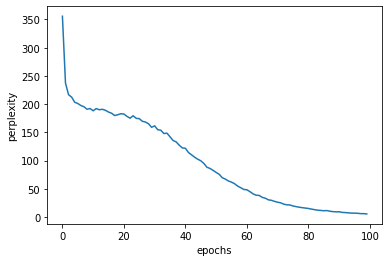

In [1]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
